# EDA species imbalance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/12 20:58:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/12 20:58:34 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/12 20:58:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
dct_emb_train = "process/training_cropped_resized_v2/dino_dct/data"
train = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_train}"
train_gcs_path = f"{gcs_path}/{train}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)
train_df.show(n=3)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|170e88ca9af457daa1038092479b251c61c64f7d.jpg|   1742956|[-20648.51, 2133.689, -2555.3125, 14820.57, 685...|
|c24a2d8646f5bc7112a39908bd2f6c45bf066a71.jpg|   1356834|[-25395.82, -12564.387, 24736.02, 20483.8, 2115...|
|e1f68e5f05618921969aee2575de20e537e6d66b.jpg|   1563754|[-26178.633, -7670.404, -22552.29, -6563.006, 8...|
|b0433cd6968b57d52e5c25dc45a28e674a25e61e.jpg|   1367432|[-23662.764, -6773.8213, -8283.518, 3769.6064, ...|
|96478a0fe20a41e755b0c8d798690f2c2b7c115f.jpg|   1389010|[-22182.172, -19444.006, 23355.23, 7042.8604, -...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

In [4]:
from pyspark.sql import functions as F

# Transformation
grouped_train_df = (
    train_df.groupBy(["species", "species_id"])
    .agg(F.count("species_id").alias("n"))
    .orderBy(F.col("n").desc())
)

# Action
grouped_train_df.show()

+--------------------+----------+---+
|             species|species_id|  n|
+--------------------+----------+---+
|Styphnolobium jap...|   1369068|823|
|Frangula alnus Mill.|   1360257|793|
|Aria edulis (Will...|   1737559|770|
|Lathyrus oleraceu...|   1741625|700|
|  Bromus sterilis L.|   1414366|674|
|   Lotus hirsutus L.|   1743246|668|
|Scandosorbus inte...|   1737669|662|
|     Hedera helix L.|   1363575|653|
|Oxalis dillenii J...|   1394359|653|
|Calicotome spinos...|   1359160|642|
|Castanea sativa M...|   1358610|638|
|Buxus semperviren...|   1356729|636|
|    Arbutus unedo L.|   1358500|634|
|Pistacia lentiscu...|   1356290|632|
|   Ulmus minor Mill.|   1360607|630|
|Tecomaria capensi...|   1400151|627|
|     Quercus ilex L.|   1357416|626|
|Calamagrostis are...|   1722433|625|
|Pittosporum tobir...|   1394624|625|
|Cercis siliquastr...|   1359162|624|
+--------------------+----------+---+
only showing top 20 rows



In [5]:
grouped_train_df.filter("n >= 100").count()

4797

In [6]:
import matplotlib.pyplot as plt


def plot_species_histogram(df, species_count: int):
    # Plotting
    plt.figure(figsize=(10, 6), dpi=100)

    # Plot all species
    df = df.filter(f"n >= {species_count}").toPandas()
    plt.bar(df["species"], df["n"], color="tab:blue")
    plt.xlabel("Species")
    plt.ylabel("Count")
    plt.title(
        f"PlantCLEF 2024 Histogram of Plant Species",
        weight="bold",
        fontsize=14,
    )
    plt.xticks([])
    plt.tight_layout()
    plt.show()

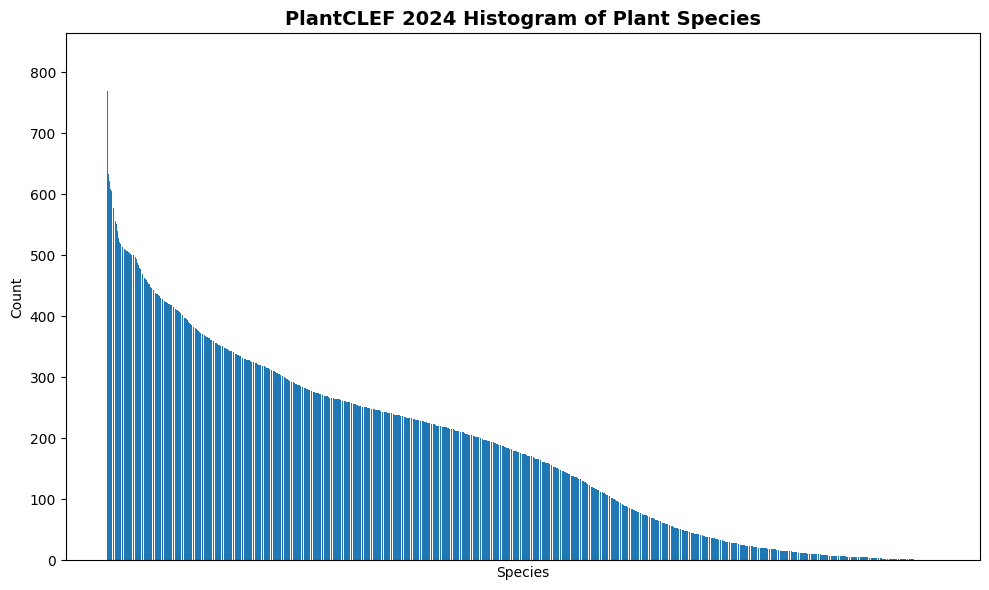

In [7]:
# Plot species
plot_species_histogram(grouped_train_df, species_count=1)

In [8]:
grouped_train_df.filter("n == 1").show(20, truncate=50)

+---------------------------------------------+----------+---+
|                                      species|species_id|  n|
+---------------------------------------------+----------+---+
|Trisetaria aurea (Ten.) Pignatti ex Kerguélen|   1743231|  1|
|                          Centaurea pinae Pau|   1502791|  1|
|                 Saxifraga × capitata Lapeyr.|   1687898|  1|
|                          Crocus clusii J.Gay|   1743927|  1|
|                       Anchusa puechii Valdés|   1477204|  1|
|                                        Inula|   1397412|  1|
|            Alyssum rhodanense Jord. & Fourr.|   1743639|  1|
|                    Myosotis soleirolii Godr.|   1478565|  1|
|                                      Lactuca|   1364172|  1|
|        Delphinium bolosii C.Blanché & Molero|   1663927|  1|
|                                     Dianthus|   1397368|  1|
|                                    Heracleum|   1360744|  1|
|                  Taraxacum lojoense H.Lindb.|   15235